In [114]:
import importlib as imp
imp.reload(t)
imp.reload(pc)
imp.reload(call)
imp.reload(leading_logic)
imp.reload(bsc)
imp.reload(points)
imp.reload(leading_alone_logic)

<module 'leading_alone_logic' from '/Users/andy/Documents/Side Projects/play-euchre/leading_alone_logic.py'>

In [1]:
import numpy as np
import basicprogs as b
import call
import leading_logic
import leading_alone_logic
import turns_and_play as t
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import showturn as s
import rule_class as rc
import play_card as pc
import points
import boardstate_class as bsc

In [2]:
names = np.array(['nine', 'ten', 'jack', 'queen', 'king', 'ace', 'null'])
suits = np.array(['clubs', 'diamonds', 'hearts', 'spades', 'null'])
def get_state(board):
    '''
    This just shows the cards on the table for this trick only.
    Each card will be OneHotEncoded as 9-A and C/D/H/S, so 10 columns per card
    Possible 3 cards out already, so 30 total columns per state, mostly zeros
    Also add the trump suit at the very end, just as a reminder
    Should I set it up so that the first 10 indices are always the 1st opponent? That might make it more helpful
    Also add in the player's hand to make it the entire environment
    '''
    state = np.zeros(4+30+50)
    suit_ix = np.argwhere(suits == board.trump_suit)[0][0]
    state[suit_ix + 30] = 1
    for c, p in board.cards_played_and_stats:
        if p == 'o1':    i = 0
        elif p == 'p':   i = 1
        elif p == 'o2':  i = 2
        else:            continue
        
        idx = np.argwhere(names==c.name)[0][0]
        idx1 = np.argwhere(suits==c.suit)[0][0]
        state[10*i + idx] = 1
        state[10*i + idx1] = 1
    
    buffer_ix = 34
    for card_num, c in enumerate(board.pos_hand_dict['d']):
        name_ix = np.argwhere(names==c.name)[0][0]
        suit_ix = np.argwhere(suits==c.suit)[0][0]
        
        state[name_ix+buffer_ix + 10*card_num] = 1
        state[suit_ix+buffer_ix + 10*card_num] = 1
        
        
    return(state)

In [5]:
def convert_random_to_cardnum(n, probas):
    if n < probas[0][0]:         return(0)
    elif n < sum(probas[0][:2]): return(1)
    elif n < sum(probas[0][:3]): return(2)
    elif n < sum(probas[0][:4]): return(3)
    else:                     return(4)

In [103]:
def dealer_illegal_card(board, dcard, penalty=-10):
    if dcard.suit == 'null':           return(penalty)
    if dcard.name == 'null':           return(penalty)
    if board.leader_pos == 'd':        return(0)
    
    if board.cards_played[0].istrump:
        # If you follow trump with trump
        if dcard.istrump:
            return(0)
        
        # Else, check if you have any trump
        for c in board.pos_hand_dict['d']:
            if c.istrump:
                return(penalty)
        return(0)
    
    else:
        led_suit = board.cards_played[0].suit
        
        # If you follow an off-suit with the off-suit
        if dcard.suit == led_suit:
            if not dcard.istrump:
                return(0)
            else:
                return(penalty)
        
        # Else, check if you have any (non-left) of the off-suit
        for c in board.pos_hand_dict['d']:
            if c.suit == led_suit and not c.istrump:
                return(penalty)
        return(0)

In [31]:
def play_a_card(board, current_pos, model, loss_fn):
    if current_pos != 'd':
        grads = None
        dcard = None
        
        # if leading
        if len(board.cards_played) == 0:
            
            # if going alone
            if board.going_alone and current_pos == board.caller_pos:
                c = leading_alone_logic.return_card(board, current_pos)
            # if not going alone
            else:
                c = leading_logic.return_card(board, current_pos)
        
        # not leading
        else:
            c = pc.pick_nonlead_card(board, current_pos)
            
        
    else:
        state = get_state(board)
        with tf.GradientTape() as tape:
            probas = model(state[np.newaxis])
            n = np.random.random()
            card_num = convert_random_to_cardnum(n, probas)
            target = tf.constant([[card_num]])
            loss = tf.reduce_mean(loss_fn(target, probas))
        grads = tape.gradient(loss, model.trainable_variables)
        
        c = board.pos_hand_dict['d'][card_num]
        dcard = c.copy()
    
    c_copy = c.copy()
    board.play_card(c.copy(), current_pos)
            
    if board.show_each_turn:   
        t.show(board)
    return(board, c_copy, grads)

In [129]:
def play_a_trick(board, model, loss_fn, penalty=-10):
    board.new_trick(board.winner_pos)
    idx = board.allpos.index(board.leader_pos)

    for i in range(4):
        k = (i + idx)%4
        current_pos = board.allpos[k]
        board, c, fakegrads = play_a_card(board, current_pos, model, loss_fn)
        if current_pos == 'd':
            dcard = c.copy()
            grads = fakegrads
    
    state = get_state(board)
    reward = board.winner_pos in ['p', 'd']
    reward += dealer_illegal_card(board, dcard, penalty)
    done = 5-sum([c.suit=='null' for c in board.pos_hand_dict['d']])
    if dealer_illegal_card(board, dcard, penalty) != 0:
        board.reneg = [True, 'd']
    board.end_trick()
    
    return(state, reward, dcard, grads)

In [140]:
def play_a_hand(board, model, loss_fn, penalty=-10):
    t.setup(board)
    current_rewards = []
    current_grads = []
    for trick in range(5):
        state, reward, dcard, grads = play_a_trick(board, model, loss_fn, penalty)
        current_rewards.append(reward)
        current_grads.append(grads)
    points.add_points(board)
    if board.show_each_turn: print(board.hand_result.capitalize())
    board.done_with_hand()
    return(current_rewards, current_grads)

def play_many_hands(model, loss_fn, N, run_quiet = True, penalty=-10):
    board = bsc.boardstate()
    if run_quiet: board.run_quiet()
    all_rewards = []
    all_grads = []
    for i in range(N):
        current_rewards, current_grads = play_a_hand(board, model, loss_fn, penalty)
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
        if not run_quiet:
            print('Rewards:', current_rewards)
    return(all_rewards, all_grads, board)

In [10]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [11]:
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.sparse_categorical_crossentropy

In [95]:
def build_model():
    model = keras.models.Sequential([
        keras.layers.Dense(60, activation='selu', input_shape=[4+30+50]),
        keras.layers.Dense(50, activation='selu'),
        keras.layers.Dense(35, activation='selu'),
        keras.layers.Dense(20, activation='selu'),
        keras.layers.Dense(5, activation='softmax')
    ])
    return(model)
model = build_model()

In [46]:
number_of_hands = 10
number_of_iters = 1
discount_rate = 0.8
for i in range(number_of_iters):
    all_rewards, all_grads, board = play_many_hands(model, loss_fn, number_of_hands)
    total_rewards = sum(map(sum, all_rewards))
    print('Iteration: %i, mean rewards: %.1f, NS-EW score: %i-%i'
          %(i+1, total_rewards/N, board.ns_score, board.ew_score))
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 1, mean rewards: -17.4, NS-EW score: 7-7


In [162]:
def train(model, N_iters, N_hands_per_iter=10, discount_rate=0.8, print_every=1, penalty=-5):
    rewards_over_time = []
    epochs = list(range(N_iters))
    for i in range(N_iters):
        all_rewards, all_grads, board = play_many_hands(model, loss_fn, N_hands_per_iter, penalty)
        total_rewards = sum(map(sum, all_rewards))
        rewards_over_time.append(total_rewards/N_hands_per_iter)
        if (i+1) % print_every == 0:
            print('Iteration: %i, mean rewards per hand: %.1f, NS-EW score: %i-%i'
                  %(i+1, total_rewards/N_hands_per_iter, board.ns_score, board.ew_score))
        all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)

        all_mean_grads = []
        for var_index in range(len(model.trainable_variables)):
            mean_grads = tf.reduce_mean(
                [final_reward * all_grads[episode_index][step][var_index]
                 for episode_index, final_rewards in enumerate(all_final_rewards)
                     for step, final_reward in enumerate(final_rewards)], axis=0)

            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    return(model, rewards_over_time, epochs)

In [51]:
train(1)

Iteration: 1, mean rewards: -14.3, NS-EW score: 8-7


In [150]:
def from_beginning():
    model = build_model()
    loss_fn = keras.losses.sparse_categorical_crossentropy
    
    model, rew, epo = train(model, 20000, print_every=1000, discount_rate=0.2)
    return(model, rew, epo)
model, rew, epo = from_beginning()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration: 1000, mean rewards per hand: -10.6, NS-EW score: 4-14
Iteration: 2000, mean rewards per hand: -2.0, NS-EW score: 5-11
Iteration: 3000, mean rewards per hand: 1.1, NS-EW score: 5-9
Iteration: 4000, mean rewards per hand: 1.7, NS-EW score: 7-6
Iteration: 5000, mean rewards per hand: -4.4, NS-EW score: 3-15
Iteration: 6000, mean rewards per hand: 0.1, NS-EW score: 7-6
Iteration: 7000, mean rewards per hand: -6.0, NS-EW score: 4-10
Iteration: 8000, mean rewards per hand: -1.4, NS-EW score: 4-13
I

In [163]:
model, rew, epo = train(model, 20000, print_every=1000, discount_rate=0.5, penalty=-5)

Iteration: 1000, mean rewards per hand: -0.2, NS-EW score: 6-8
Iteration: 2000, mean rewards per hand: -2.3, NS-EW score: 4-11
Iteration: 3000, mean rewards per hand: -0.4, NS-EW score: 5-8
Iteration: 4000, mean rewards per hand: -7.6, NS-EW score: 3-14
Iteration: 5000, mean rewards per hand: -3.1, NS-EW score: 5-11
Iteration: 6000, mean rewards per hand: -3.0, NS-EW score: 9-8
Iteration: 7000, mean rewards per hand: -0.9, NS-EW score: 3-15
Iteration: 8000, mean rewards per hand: 1.8, NS-EW score: 8-5
Iteration: 9000, mean rewards per hand: -5.0, NS-EW score: 1-16
Iteration: 10000, mean rewards per hand: -0.7, NS-EW score: 4-9
Iteration: 11000, mean rewards per hand: 0.9, NS-EW score: 7-10
Iteration: 12000, mean rewards per hand: -1.2, NS-EW score: 5-11
Iteration: 13000, mean rewards per hand: -2.8, NS-EW score: 6-10
Iteration: 14000, mean rewards per hand: -1.9, NS-EW score: 8-10
Iteration: 15000, mean rewards per hand: -3.0, NS-EW score: 4-11
Iteration: 16000, mean rewards per hand: 

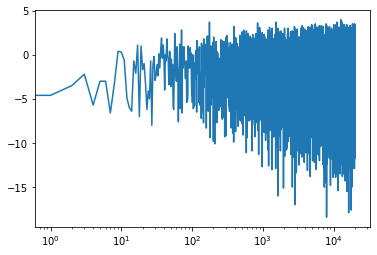

In [179]:
import matplotlib.pyplot as plt
plt.plot(epo, rew)
plt.xscale('log')
plt.show()

In [177]:
N = 5
r, g, b = play_many_hands(model, loss_fn, N, run_quiet=True, penalty=-5)
print(r)
print(sum(map(sum, r))/N)
print(b.ns_score, b.ew_score)

[[1, 1, -5, 0, 1], [0, 1, 1, 0, 1], [0, 0, 1, 1, 1], [1, 1, 0, 1, 1], [1, 1, 1, 1, 1]]
2.6
5 2


In [180]:
r, g, b = play_many_hands(model, loss_fn, 1, run_quiet=False)

o1 :  42.0 		First Round
p :  53.5 		First Round
o2 :  73.0 		First Round
--------------------------------
	  9 Qu  9 Ki Ja
	  C  D  D  H  S

Ja C			  	C Ki
10 C			  	H Ac
Ac D			  	H Qu
Ja D			  	S Ac
10 H			  	S Qu

	  C  C  D  D  S
	 Ac Qu Ki 10 10
--------------------------------
NS score:  0		 EW score:  0
NS tricks: 0		 EW tricks: 0

Trump suit: **Spades**, called by: o2
Called first round. Turn card was the Ten of Spades

o1 led this trick, and o1 is winning right now.
--------------------------------
enter "c" to continue, "x" to exit: c
--------------------------------
	  9 Qu  9 Ki Ja
	  C  D  D  H  S

10 C			  	C Ki
-- -			  	H Ac
Ja D	Ac D	    	  	H Qu
10 H			  	S Ac
Ja C			  	S Qu

	  C  C  D  D  S
	 Ac Qu Ki 10 10
--------------------------------
NS score:  0		 EW score:  0
NS tricks: 0		 EW tricks: 0

Trump suit: **Spades**, called by: o2
Called first round. Turn card was the Ten of Spades

o1 led this trick, and o1 is winning right now.
--------------------------------


enter "c" to continue, "x" to exit: c
--------------------------------
	  9 -- -- -- --
	  C  -  -  -  -

10 C			  	- --
-- -			  	- --
-- -		    Qu H  	- --
-- -			  	- --
-- -			  	- --

	  -  C  -  -  -
	 -- Qu -- -- --
--------------------------------
NS score:  0		 EW score:  0
NS tricks: 1		 EW tricks: 3

Trump suit: **Spades**, called by: o2
Called first round. Turn card was the Ten of Spades

o2 led this trick, and o2 is winning right now.
--------------------------------
enter "c" to continue, "x" to exit: c
--------------------------------
	  9 -- -- -- --
	  C  -  -  -  -

10 C			  	- --
-- -			  	- --
-- -		    Qu H  	- --
-- -			  	- --
-- -	      Qu C	  	- --

	  -  -  -  -  -
	 -- -- -- -- --
--------------------------------
NS score:  0		 EW score:  0
NS tricks: 1		 EW tricks: 3

Trump suit: **Spades**, called by: o2
Called first round. Turn card was the Ten of Spades

o2 led this trick, and o2 is winning right now.
--------------------------------
enter "c" to continue

In [149]:
model_saved = model
model_saved.save('EarlyModel.h5')